# Evaluating your SAE

Code based off Rob Graham's ([themachinefan](https://github.com/themachinefan)) SAE evaluation code.

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [3]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig

@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    sae_path: str = '/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-8e-05/n_images_2600058.pt'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32

    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [4]:
torch.set_grad_enabled(False)

## Load model

In [5]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [6]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [7]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [8]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [9]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained("/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-8e-05/n_images_2600058.pt")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 


get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

## Clip Labeling AutoInterp

In [10]:
# all_imagenet_class_names

In [16]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [17]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-8e-05/layer_9'

## Feature steering

In [18]:
def standard_replacement_hook_curry(feat_idx: int = 0, feat_activ: float = 1.0):
    def standard_replacement_hook(activations: torch.Tensor, hook):
        activations = sparse_autoencoder.forward(activations)[0].to(activations.dtype)
        feature_acts = sparse_autoencoder.encode_standard(activations)

        # in all batches and patches, set feature w idx idx to 0
        print(f"feature_acts[:,:,idx].shape: {feature_acts[:,:,feat_idx].shape}")
        print(f"feat activ: {feature_acts[:,:,feat_idx]}")
        feature_acts[:,:,feat_idx] *= feat_activ
        print(f"feat activ: {feature_acts[:,:,feat_idx]}")
        print(f"feat activ: {feature_acts.shape}")
        print(f"feat activ: {feature_acts}")
        print("feature_acts[:,:,idx].sum(): (should be batch size x len seq x feat val)", feature_acts[:,:,feat_idx].sum())
        sae_out = sparse_autoencoder.hook_sae_out(
            einops.einsum(
                feature_acts,
                sparse_autoencoder.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            )
            + sparse_autoencoder.b_dec
        )
        
        print(f"sae_out.shape: {sae_out.shape}")
        print(f"sae_out: {sae_out}")

        # allows normalization. Possibly identity if no normalization
        sae_out = sparse_autoencoder.run_time_activation_norm_fn_out(sae_out)
        return sae_out
    return standard_replacement_hook


def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    print(steered_sae_out.shape)
    print(steered_sae_out.shape)
    print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [19]:
random_feat_idxs = np.random.randint(0, high=3000, size=(10))

In [20]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
    _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
#     recons_image_embeddings_feat_altered = model.run_with_hooks(
#         images,
#         fwd_hooks=[("blocks.9.hook_mlp_out", standard_replacement_hook)],
#     )
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
        print(f"Feature: {idx} ====================")
        
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=10.0,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
#             fwd_hooks=[("blocks.9.hook_mlp_out", standard_replacement_hook_curry(idx, 10.0))],
            fwd_hooks=[("blocks.9.hook_mlp_out", steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[("blocks.9.hook_mlp_out", lambda x, hook: x)],
    )
    
    print(f"recons_image_embeddings_default: {recons_image_embeddings_default}")
    print(f"recons_image_embeddings_default.shape: {recons_image_embeddings_default.shape}")
    print(f"recons_image_embeddings_default: {recons_image_embeddings_default.shape}")

    print(f"recons_image_embeddings_feat_altered: {recons_image_embeddings_feat_altered}")
    print(f"recons_image_embeddings_feat_altered.shape: {recons_image_embeddings_feat_altered.shape}")

    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

In [21]:
max_samples = cfg.eval_max

# top_activations = {i: (None, None) for i in interesting_features_indices}
encoder_biases = sparse_autoencoder.b_enc#[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc#[:, interesting_features_indices]

top_k=10
processed_samples = 0
for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
    batch_images = batch_images.to(cfg.device)
    batch_indices = batch_indices.to(cfg.device)
    batch_size = batch_images.shape[0]

    altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
        batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
        None, None, top_k
    )
    # either label embeds or optimize to maximal token in text transformer embedding face
    break

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]

Feature: 2771 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 392.91650390625
error.norm(): 3454.123291015625
Feature: 498 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 399.28857421875
error.norm(): 3454.123291015625
Feature: 2416 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 399.6461181640625
error.norm(): 3454.123291015625
Feature: 1884 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 399.8929443359375
error.norm(): 3454.123291015625
Feature: 1919 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 399.7402038574219
error.norm(): 3454.123291015625
Feature: 325 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steering norm: 399.3807373046875
error.norm(): 3454.123291015625
Feature: 1361 ====================
torch.Size([32, 50, 768])
torch.Size([32, 50, 768])
steerin

  0%|                                                                                                            | 0/1562 [00:01<?, ?it/s]

recons_image_embeddings_default: tensor([[ 0.0352,  0.0083, -0.0740,  ..., -0.0311,  0.0275,  0.0019],
        [-0.0101, -0.0539, -0.0622,  ...,  0.0199, -0.0555, -0.0743],
        [-0.0206,  0.0059, -0.0366,  ..., -0.0307,  0.0756, -0.0016],
        ...,
        [ 0.0099, -0.0045, -0.0059,  ..., -0.0521,  0.0647, -0.0225],
        [-0.0422,  0.0518, -0.0482,  ...,  0.0098,  0.0418,  0.0290],
        [-0.0411, -0.0590,  0.0014,  ..., -0.0432, -0.0089, -0.0449]],
       device='cuda:0')
recons_image_embeddings_default.shape: torch.Size([32, 512])
recons_image_embeddings_default: torch.Size([32, 512])
recons_image_embeddings_feat_altered: tensor([[ 0.0419, -0.0096, -0.0221,  ..., -0.0297,  0.0031,  0.0080],
        [ 0.0410, -0.0241, -0.0347,  ...,  0.0109, -0.0632, -0.0341],
        [ 0.0107, -0.0120, -0.0302,  ..., -0.0256,  0.0652,  0.0181],
        ...,
        [ 0.0377,  0.0117,  0.0167,  ..., -0.0548,  0.0238, -0.0410],
        [-0.0003,  0.0449, -0.0210,  ...,  0.0238,  0.0141,  0

In [22]:
len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

(10, torch.Size([32, 512]), torch.Size([32, 512]))

In [23]:
og_model.cuda()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [24]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(all_imagenet_class_names)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)

text_probs_altered_list = []
# can probs make this one tensor operation
for altered_embeds in altered_embeds_list:
    with torch.no_grad(), torch.cuda.amp.autocast():
        # might want to still normalize
        
        # already normalized
        # altered_embeds /= altered_embeds.norm(dim=-1, keepdim=True)

        text_probs_altered = (100.0 * altered_embeds @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    # default_embds_norm = default_embeds.norm(dim=-1, keepdim=True)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

Label probs altered: torch.Size([32, 1000])
Label probs default: torch.Size([32, 1000])


In [25]:
text_probs_altered

tensor([[1.1508e-09, 9.5408e-10, 2.3248e-09,  ..., 1.4181e-10, 1.0545e-06,
         2.9388e-09],
        [9.0005e-05, 8.8743e-08, 1.2373e-05,  ..., 4.2083e-08, 4.6498e-07,
         1.0981e-06],
        [6.1068e-10, 3.5429e-07, 1.2214e-10,  ..., 3.8666e-10, 2.4262e-05,
         1.4654e-07],
        ...,
        [2.1050e-08, 2.3774e-04, 1.2092e-06,  ..., 3.8048e-07, 5.1710e-06,
         2.6205e-06],
        [5.6236e-10, 1.2049e-07, 1.0713e-09,  ..., 6.7427e-11, 5.6033e-08,
         6.7063e-08],
        [2.0911e-07, 4.7765e-08, 5.4665e-07,  ..., 1.4424e-09, 5.3398e-07,
         1.0894e-05]], device='cuda:0')

In [46]:
# subtract from default, label, and print trends
text_probs_altered.shape

for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"For Feature {random_feat_idxs[j]}")
    logit_diff = text_probs_altered - text_probs_default
    logit_ratio = text_probs_altered/text_probs_default
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    for i in range(logit_diff.shape[0]):
        print(f"\nImage {i} ========================\nMost Changed, by Absolute Diff\n:{vals[i]}")
        print(np.array(all_imagenet_class_names)[idxs.cpu()][i])
        print(vals_least[i])
        print(np.array(all_imagenet_class_names)[idxs_least.cpu()][i])
        
        print("Most Changed, by Ratio:")
        print(ratios[i])
        print(np.array(all_imagenet_class_names)[ratios_idxs.cpu()][i])
        print(ratios_least[i])
        print(np.array(all_imagenet_class_names)[ratios_idxs_least.cpu()][i])
    break

For Feature 2771

Image 0 ========================
Most Changed, by Absolute Diff
:tensor([0.0324, 0.0059, 0.0012, 0.0010, 0.0010], device='cuda:0')
['sea_snake' 'thunder_snake' 'sidewinder' 'night_snake' 'nematode']
tensor([-0.0289, -0.0059, -0.0030, -0.0012, -0.0011], device='cuda:0')
['water_snake' 'garter_snake' 'ringneck_snake' 'eel' 'rock_python']
Most Changed, by Ratio:
tensor([169.5721, 162.9211, 157.8700, 131.6811, 118.7182], device='cuda:0')
['sundial' 'safe' 'picket_fence' 'four-poster' 'home_theater']
tensor([0.0103, 0.0186, 0.0279, 0.0296, 0.0325], device='cuda:0')
['spotted_salamander' 'tench' 'European_gallinule' 'American_coot'
 'unicycle']

Image 1 ========================
Most Changed, by Absolute Diff
:tensor([0.1870, 0.0097, 0.0087, 0.0072, 0.0058], device='cuda:0')
['dogsled' 'ibex' 'snowmobile' 'Bernese_mountain_dog' 'ski_mask']
tensor([-2.4146e-01, -7.9284e-04, -3.9265e-04, -1.8868e-04, -2.3822e-05],
       device='cuda:0')
['ski' 'plow' 'bighorn' 'paddle' 'couga

In [46]:
top_k_imgnet_labels = 10

In [47]:
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

feat_autolabels_default = defaultdict(Counter)
for i in range(text_probs_default.shape[0]):
    vals, idxs = torch.topk(text_probs_default[i],k=top_k_imgnet_labels)
    print(i)
    for k, idx in enumerate(idxs):
        feat_autolabels_default[i][all_imagenet_class_names[idx]] += vals[k]
        print("\t", all_imagenet_class_names[idx])
feat_autolabels_default

0
	 sea_snake
	 water_snake
	 garter_snake
	 rock_python
	 ringneck_snake
	 night_snake
	 thunder_snake
	 eel
	 Indian_cobra
	 sandbar
1
	 ski
	 gondola
	 ibex
	 alp
	 plow
	 ski_mask
	 snowmobile
	 pole
	 bighorn
	 patas
2
	 collie
	 Shetland_sheepdog
	 Border_collie
	 papillon
	 borzoi
	 Blenheim_spaniel
	 Japanese_spaniel
	 Eskimo_dog
	 Angora
	 Sealyham_terrier
3
	 soup_bowl
	 consomme
	 eggnog
	 mixing_bowl
	 ladle
	 cup
	 butternut_squash
	 spaghetti_squash
	 measuring_cup
	 pot
4
	 crib
	 cradle
	 bassinet
	 teddy
	 sleeping_bag
	 hamper
	 Model_T
	 toyshop
	 crate
	 radiator
5
	 green_snake
	 garter_snake
	 sea_snake
	 ringneck_snake
	 thunder_snake
	 vine_snake
	 Indian_cobra
	 water_snake
	 horned_viper
	 king_snake
6
	 porcupine
	 echidna
	 sloth_bear
	 skunk
	 sea_lion
	 guinea_pig
	 colobus
	 coucal
	 African_grey
	 mongoose
7
	 confectionery
	 bath_towel
	 bakery
	 ice_cream
	 cab
	 velvet
	 lycaenid
	 vending_machine
	 hamper
	 menu
8
	 mousetrap
	 mouse
	 frilled_lizard

defaultdict(collections.Counter,
            {0: Counter({'sea_snake': tensor(0.9421, device='cuda:0'),
                      'water_snake': tensor(0.0314, device='cuda:0'),
                      'garter_snake': tensor(0.0063, device='cuda:0'),
                      'rock_python': tensor(0.0041, device='cuda:0'),
                      'ringneck_snake': tensor(0.0032, device='cuda:0'),
                      'night_snake': tensor(0.0022, device='cuda:0'),
                      'thunder_snake': tensor(0.0017, device='cuda:0'),
                      'eel': tensor(0.0014, device='cuda:0'),
                      'Indian_cobra': tensor(0.0014, device='cuda:0'),
                      'sandbar': tensor(0.0013, device='cuda:0')}),
             1: Counter({'ski': tensor(0.9817, device='cuda:0'),
                      'gondola': tensor(0.0028, device='cuda:0'),
                      'ibex': tensor(0.0028, device='cuda:0'),
                      'alp': tensor(0.0022, device='cuda:0'),
             

In [55]:
# subtract from default, label, and print trends
text_probs_altered.shape

for text_probs_altered in text_probs_altered_list:
    logit_diff = text_probs_altered - text_probs_default
    print(logit_diff)
    vals, idxs = torch.topk(logit_diff,k=5)
    print(vals, np.array(all_imagenet_class_names[idxs])
    break

tensor([[-4.9552e-09,  7.7888e-09, -3.5309e-10,  ..., -1.7523e-09,
          1.2370e-05,  1.5179e-06],
        [-1.3950e-06,  2.1421e-09, -1.4217e-06,  ..., -4.1809e-08,
         -1.0884e-07,  7.1049e-07],
        [ 1.1003e-09,  2.0618e-06,  2.7316e-10,  ...,  7.7609e-10,
          6.3670e-05,  1.1064e-05],
        ...,
        [-3.6799e-09, -1.9469e-05, -3.1392e-07,  ..., -1.8231e-07,
          9.1288e-07, -1.8024e-07],
        [-1.9719e-10,  2.2241e-07, -1.3025e-10,  ..., -6.4752e-10,
          2.3635e-09,  1.3694e-07],
        [-1.3110e-07,  5.8447e-09,  4.7793e-08,  ...,  1.7158e-09,
          5.0481e-07,  9.3521e-06]], device='cuda:0')


TypeError: only integer tensors of a single element can be converted to an index

In [56]:
all_imagenet_class_names

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house_finch',
 'junco',
 'indigo_bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water_ouzel',
 'kite',
 'bald_eagle',
 'vulture',
 'great_grey_owl',
 'European_fire_salamander',
 'common_newt',
 'eft',
 'spotted_salamander',
 'axolotl',
 'bullfrog',
 'tree_frog',
 'tailed_frog',
 'loggerhead',
 'leatherback_turtle',
 'mud_turtle',
 'terrapin',
 'box_turtle',
 'banded_gecko',
 'common_iguana',
 'American_chameleon',
 'whiptail',
 'agama',
 'frilled_lizard',
 'alligator_lizard',
 'Gila_monster',
 'green_lizard',
 'African_chameleon',
 'Komodo_dragon',
 'African_crocodile',
 'American_alligator',
 'triceratops',
 'thunder_snake',
 'ringneck_snake',
 'hognose_snake',
 'green_snake',
 'king_snake',
 'garter_snake',
 'water_snake',
 'vine_snake',
 'night_snake',
 'boa_constrictor',
 'rock_python',
 'Indian_cobr

In [49]:
from collections import defaultdict, Counter

feat_autolabels_altered_list = []
for text_probs_altered in text_probs_altered_list:
    feat_autolabels_altered = defaultdict(Counter)
    for i in range(text_probs_altered.shape[0]):
        vals, idxs = torch.topk(text_probs_altered[i],k=top_k_imgnet_labels)
#         print(i)
        for k, idx in enumerate(idxs):
            feat_autolabels_altered[i][all_imagenet_class_names[idx]] += vals[k]
#             print("\t", all_imagenet_class_names[idx])
    feat_autolabels_altered_list.append(feat_autolabels_altered)

start_idx = 9
end_idx = 10
    
h = 0
for key in feat_autolabels_default:
    print(f"\nfeat_autolabels_default img {key}:\n {feat_autolabels_default[key]}\n")
    h += 1
    if h > end_idx:
        break
for i, f_a_a in enumerate(feat_autolabels_altered_list):
    print("============= feature number ", i, "====================")
    h = 0
    for key in range(start_idx, end_idx):
#         print("\n", key)
#         for item in f_a_a[key]:
#             print("\t", item, f_a_a[key][item].cpu().item())
        print(f"\nf_a_a img {key}:\n {f_a_a[key]}\n")



feat_autolabels_default img 0:
 Counter({'sea_snake': tensor(0.9421, device='cuda:0'), 'water_snake': tensor(0.0314, device='cuda:0'), 'garter_snake': tensor(0.0063, device='cuda:0'), 'rock_python': tensor(0.0041, device='cuda:0'), 'ringneck_snake': tensor(0.0032, device='cuda:0'), 'night_snake': tensor(0.0022, device='cuda:0'), 'thunder_snake': tensor(0.0017, device='cuda:0'), 'eel': tensor(0.0014, device='cuda:0'), 'Indian_cobra': tensor(0.0014, device='cuda:0'), 'sandbar': tensor(0.0013, device='cuda:0')})


feat_autolabels_default img 1:
 Counter({'ski': tensor(0.9817, device='cuda:0'), 'gondola': tensor(0.0028, device='cuda:0'), 'ibex': tensor(0.0028, device='cuda:0'), 'alp': tensor(0.0022, device='cuda:0'), 'plow': tensor(0.0019, device='cuda:0'), 'ski_mask': tensor(0.0009, device='cuda:0'), 'snowmobile': tensor(0.0009, device='cuda:0'), 'pole': tensor(0.0006, device='cuda:0'), 'bighorn': tensor(0.0006, device='cuda:0'), 'patas': tensor(0.0004, device='cuda:0')})


feat_autolabe

In [ ]:
for i in range(text_probs_default.shape[0]):
    vals, idxs = torch.topk(text_probs_default[i],k=1000)
    print(i, ind_to_name[str(idxs[0].cpu().item())][1])
    fig, ax = plt.subplots(figsize=(10, 10))
#     ax.xaxis.set_ticks((1000))
#     ax.set_xticks(list(range(1000)), [ind_to_name[str(idxs[idx].cpu().item())][1] for idx in idxs])
    plt.bar(idxs.cpu(), vals.cpu(), width=5)
    break

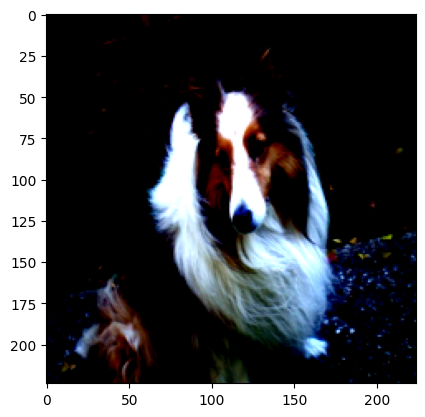

In [36]:
plt.imshow(batch_images[2].cpu().permute((1,2,0)).numpy())

In [27]:

@torch.no_grad()
def get_heatmap(
          image,
          model,
          sparse_autoencoder,
          feature_id,
): 
    image = image.to(cfg.device)
    _, cache = model.run_with_cache(image.unsqueeze(0))

    post_reshaped = einops.rearrange(cache[sparse_autoencoder.cfg.hook_point], "batch seq d_mlp -> (batch seq) d_mlp")
    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code is copied from the first part of the 'forward' method of the AutoEncoder class
    sae_in =  post_reshaped - sparse_autoencoder.b_dec # Remove decoder bias as per Anthropic
    print(f"sae_in.shape: {sae_in.shape}")
    acts = einops.einsum(
            sae_in,
            sparse_autoencoder.W_enc[:, feature_id],
            "x d_in, d_in -> x",
        )
    return acts 
     
def image_patch_heatmap(activation_values,image_size=224, pixel_num=14):
    activation_values = activation_values.detach().cpu().numpy()
    activation_values = activation_values[1:]
    activation_values = activation_values.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values[i, j]

    return heatmap


sae_in.shape: torch.Size([50, 768])


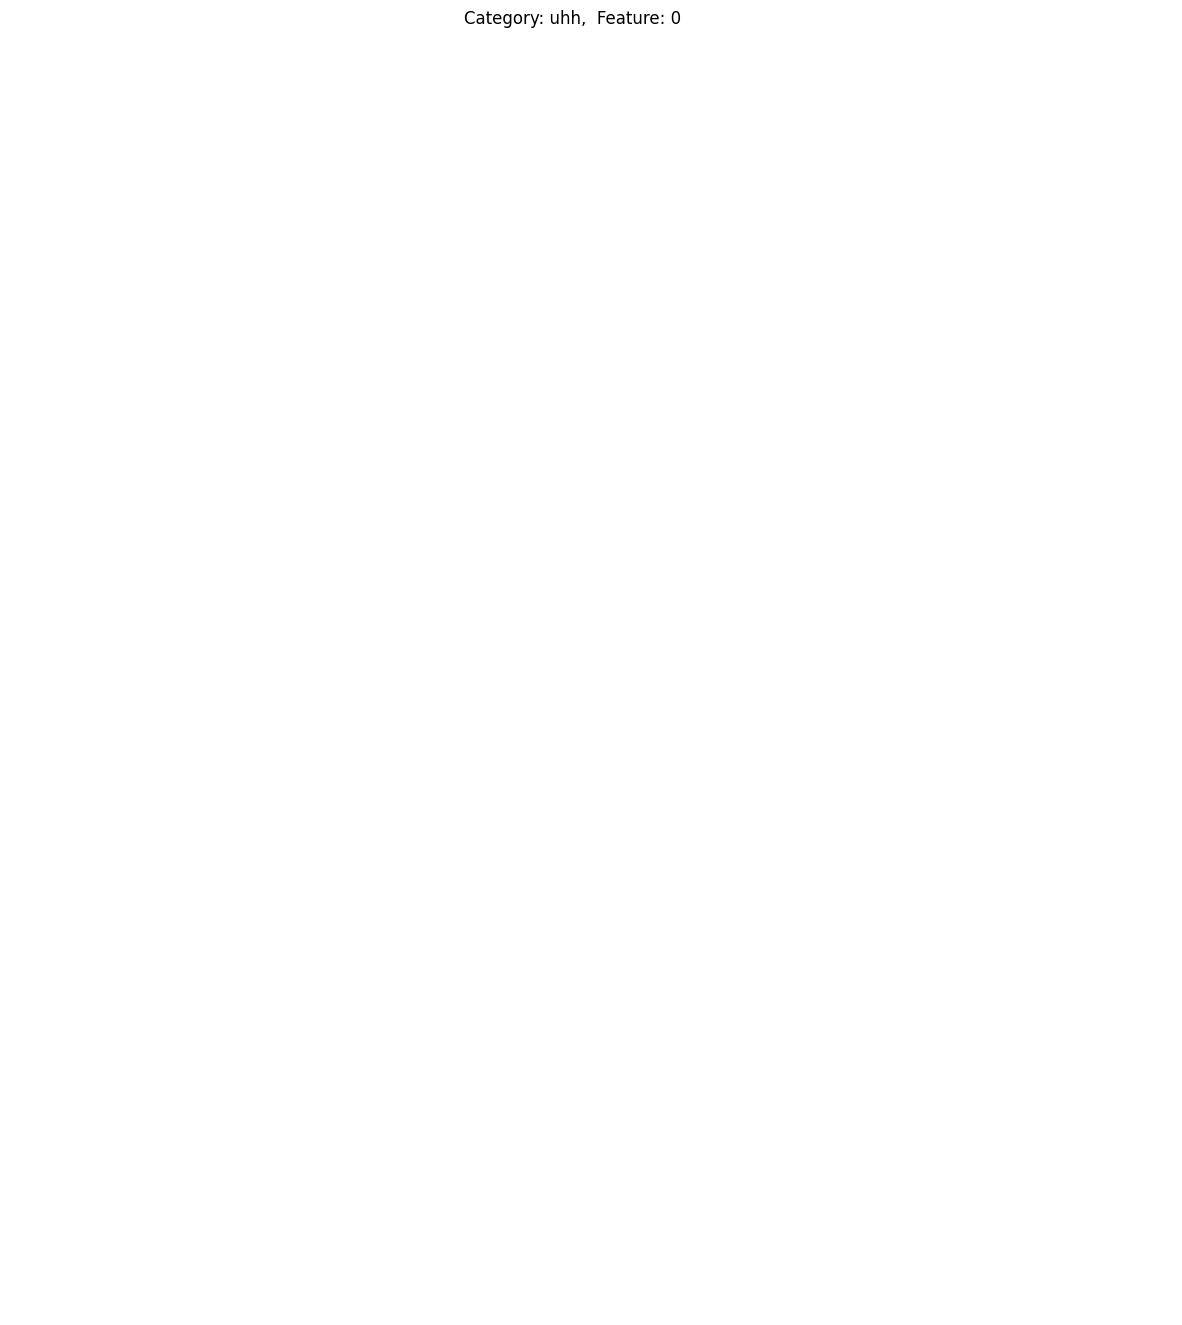

In [38]:
from matplotlib import pyplot as plt

grid_size = 1
fig, axs = plt.subplots(int(np.ceil(len(images)/grid_size)), grid_size, figsize=(15, 15))
name=  f"Category: uhh,  Feature: {0}"
fig.suptitle(name)#, y=0.95)
for ax in axs.flatten():
    ax.axis('off')
complete_bid = []

heatmap = get_heatmap(batch_images[2], model,sparse_autoencoder, 10000)
heatmap = image_patch_heatmap(heatmap, pixel_num=224//cfg.patch_size)

display = batch_images[2].cpu().numpy().transpose(1, 2, 0)

has_zero = False

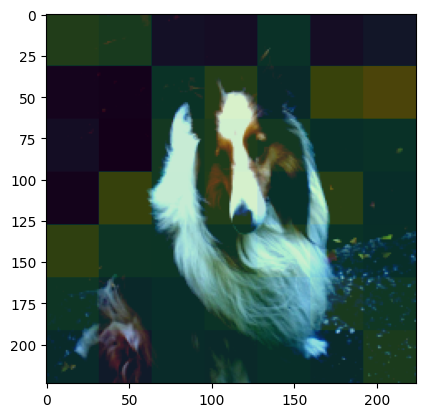

In [35]:
plt.imshow(display)
plt.imshow(heatmap, alpha=0.3)

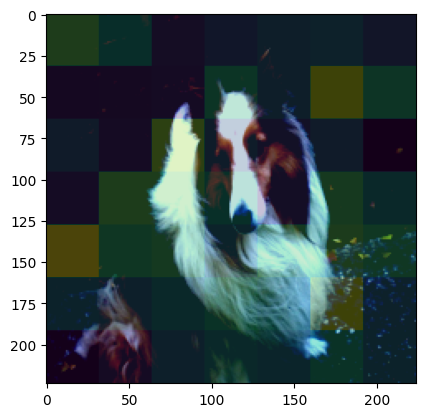

In [39]:
plt.imshow(display)
plt.imshow(heatmap, alpha=0.3)